# PINN for PDEs with two inputs

Here we consider the 1D wave equation with inputs $x$ and $t$, 

$$
 \frac{\partial^2 f}{\partial t^2} - v\cdot \frac{\partial^2 f}{\partial x^2} = 0
$$

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100  
plt.ioff()


## Defnining a general neural network class

In [2]:
class NN(tf.keras.Model):
    def __init__(
            self, 
            num_inputs: int=1,
            num_hidden_layers: int=1,
            num_neurons: int=1,
            activation: str = 'tanh'
    )->None:
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons

        NNLayers = []
        for _ in range(num_hidden_layers):
            NNLayers.append(tf.keras.layers.Dense(units=num_neurons, activation=activation)) # the hidden layers
        NNLayers.append(tf.keras.layers.Dense(units=1)) # the output layer

        self.NNLayers = NNLayers

    def call(
            self,
            input: tf.Tensor
    )->tf.Tensor: # the neural network call implements the forward call, where it runs the input through the first layer, and then feeds the output of the first layer to the second layer and so on
        output = tf.reshape(input, shape=(-1, self.num_inputs))
        for layer in self.NNLayers:
            output = layer(output)
        return output


## Problem specific defninition of the loss function

In [3]:
NUM_LAYERS = 7
NUM_NEURONS = 7
EPOCHS = 1000 #how many times the training step is performed
BATCH_SIZE = 20 # how many input values are considered for each epoch
LEARNING_RATE = 1e-2
TOLERANCE = 5e-4
NUM_INPUTS = 2

T_DOMAIN = (0.0, 5.0)
X_DOMAIN = (0.0, 2*np.pi)
T_BOUNDARY = tf.concat([tf.linspace(X_DOMAIN[0], X_DOMAIN[1], BATCH_SIZE)[:, tf.newaxis], tf.fill([BATCH_SIZE,1], T_DOMAIN[0])], axis=1)
X_BOUNDARY_0 = tf.concat([tf.fill([BATCH_SIZE,1], X_DOMAIN[0]), tf.linspace(T_DOMAIN[0], T_DOMAIN[1], BATCH_SIZE)[:, tf.newaxis]], axis=1)
X_BOUNDARY_1 = tf.concat([tf.fill([BATCH_SIZE,1], X_DOMAIN[1]), tf.linspace(T_DOMAIN[0], T_DOMAIN[1], BATCH_SIZE)[:, tf.newaxis]], axis=1)

In [4]:


def loss_fun(
        model: tf.keras.Model,
        input: tf.Tensor
)->tf.Tensor:
    x = tf.gather(input, [0], axis=1)
    t = tf.gather(input, [1], axis=1)
    with tf.GradientTape(persistent=True) as tape: # required in order to calculate the derivatives
        tape.watch(x)
        tape.watch(t)
        u = model(tf.concat([x,t], axis=1))
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t) 

    u_xx = tape.gradient(u_x, x) 
    u_tt = tape.gradient(u_t, t) 

    pde = u_tt - u_xx # the PDE 
    boundary_t = model(T_BOUNDARY) - tf.math.sin(tf.gather(T_BOUNDARY, [0], axis=1)- tf.gather(T_BOUNDARY, [1], axis=1)) # boundary condition sin wave at t=0
    boundary_x_0 = model(X_BOUNDARY_0) - tf.math.sin(tf.gather(X_BOUNDARY_0, [0], axis=1) - tf.gather(X_BOUNDARY_0, [1], axis=1)) # boundary condition sin wave at x=0
    boundary_x_1 = model(X_BOUNDARY_1) - tf.math.sin(tf.gather(X_BOUNDARY_1, [0], axis=1) - tf.gather(X_BOUNDARY_1, [1], axis=1)) # boundary condition sin wave at x=0
    interior_loss = tf.reduce_mean(tf.square(pde)) # mean square of the PDE forms the PDE loss
    boundary_loss = tf.reduce_mean(tf.square(boundary_t) + tf.square(boundary_x_0) + tf.square(boundary_x_1)) # square of the boundary term forms the boundary loss

    loss = interior_loss + boundary_loss

    return loss

## Training the model!

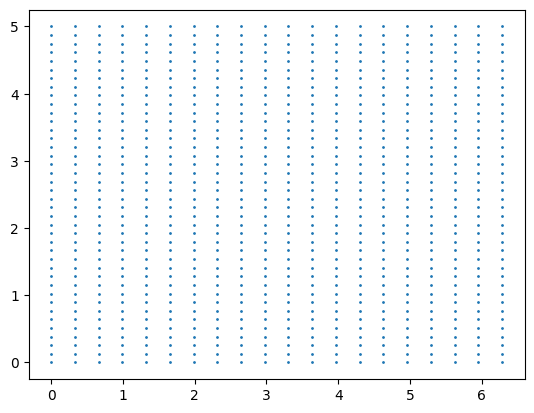

In [5]:
x_plot = tf.linspace(X_DOMAIN[0], X_DOMAIN[1], BATCH_SIZE)[:, tf.newaxis]
t_plot = tf.linspace(T_DOMAIN[0], T_DOMAIN[1], 2*BATCH_SIZE)[:, tf.newaxis]
X_mesh, T_mesh = tf.meshgrid(x_plot, t_plot)
X_pred = tf.reshape(X_mesh, shape=(-1, 1))
T_pred = tf.reshape(T_mesh, shape=(-1, 1))

plt.scatter(X_pred, T_pred, s=1)
plt.show()

In [6]:
INPUT = tf.concat([X_pred, T_pred], axis=1)

model = NN(num_inputs=NUM_INPUTS, num_hidden_layers= NUM_LAYERS, num_neurons=NUM_NEURONS)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

def train_step(model, input): # function for one single training step
    with tf.GradientTape() as tape:
        loss = loss_fun(model, input)

    gradients = tape.gradient(loss, model.trainable_variables) # calculate the gradients of the loss with respect to \theta
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # optimize the parameters to minimize the loss

    return loss

for epoch in range(EPOCHS):
    # input_batch = tf.keras.random.uniform(shape=(BATCH_SIZE, NUM_INPUTS), minval=[X_DOMAIN[0], T_DOMAIN[0]], maxval=[X_DOMAIN[1], T_DOMAIN[1]], dtype=tf.float32) #randomly sample BATCH_SIZE number of points from the domain
    loss = train_step(model, INPUT) # run the train step for the given batch
    if epoch % 50 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')
    if loss<=TOLERANCE:
        break



Epoch: 0, Loss: 1.5428440570831299
Epoch: 50, Loss: 0.15016159415245056
Epoch: 100, Loss: 0.031907472759485245
Epoch: 150, Loss: 0.011199882254004478
Epoch: 200, Loss: 0.002498958958312869
Epoch: 250, Loss: 0.0020248207729309797
Epoch: 300, Loss: 0.006060747429728508
Epoch: 350, Loss: 0.0020157801918685436
Epoch: 400, Loss: 0.001382531481795013
Epoch: 450, Loss: 0.0009890537476167083
Epoch: 500, Loss: 0.0040325867012143135
Epoch: 550, Loss: 0.0008748344262130558
Epoch: 600, Loss: 0.0007728192722424865
Epoch: 650, Loss: 0.0006316059152595699
Epoch: 700, Loss: 0.0006879409775137901
Epoch: 750, Loss: 0.0005827894201502204
Epoch: 800, Loss: 0.0016144549008458853
Epoch: 850, Loss: 0.02000165916979313
Epoch: 900, Loss: 0.0006502393516711891
Epoch: 950, Loss: 0.0013560197548940778


## Prediction and Plotting!

In [7]:
y_pred = model(INPUT)

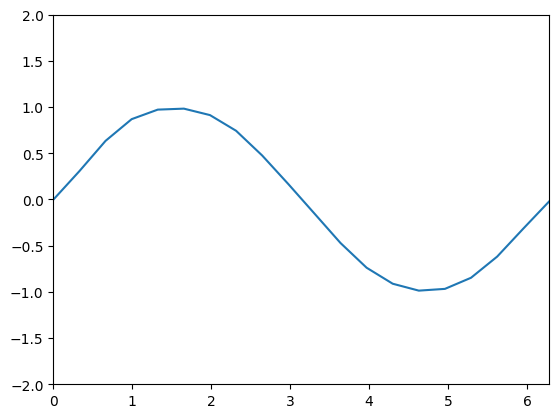

In [8]:
from time import sleep

fig, ax = plt.subplots()
ax.grid(True)

def animate(i):
    plt.cla()
    plt.plot(x_plot, y_pred[i*BATCH_SIZE : (i+1)*BATCH_SIZE])
    plt.xlim(X_DOMAIN[0], X_DOMAIN[1])  
    plt.ylim(-2,2)

matplotlib.animation.FuncAnimation(fig, animate, frames=2*BATCH_SIZE)


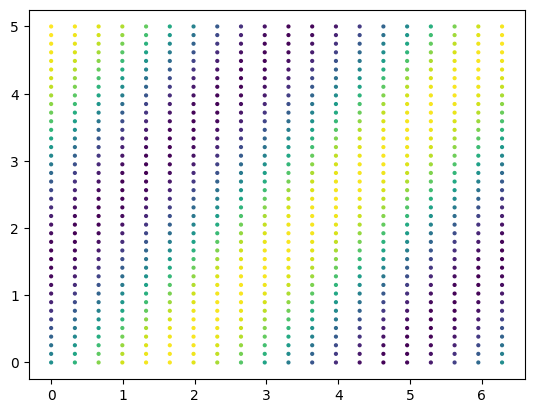

In [9]:
plt.scatter(X_pred, T_pred, c=y_pred, s=4)